<a href="https://colab.research.google.com/github/kanru-wang/Graph_Neural_Network/blob/main/Node_Classification_Subgraph_Partition_Customized_Aggregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### PubMed Node Classification with Subgraph Partitioning and Customized Message-Passing Aggregations

Given the ground-truth labels of a small subset of nodes, the task is to infer the labels for all the remaining nodes.

See: https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


The `PubMed` dataset has 3 Classes. The number of node features is 500.

In [2]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('==================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===============================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 60
Training node label rate: 0.003
Has isolated nodes: False
Has self-loops: False
Is undirected: True


## Cluster-GCN Subgraph Partitioning

Without Cluster-GCN, we would have to train GNNs for node classification tasks only in a full-batch fashion. Every node's hidden representation is computed in parallel and is available to re-use in the next layer. But the problem is that this method takes too much GPU memory.

Cluster-GCN pre-partitions the graph into subgraphs on which one can operate in a mini-batch fashion. GNNs are restricted to solely convolve inside their specific subgraphs.

However, after the graph is partitioned, some links are removed which may limit the model's performance due to a biased estimation. To address this issue, Cluster-GCN also incorporates between-cluster links inside a mini-batch, which results in the stochastic partitioning scheme in below. Here, colors represent the adjacency information that is maintained per batch (which is potentially different for every epoch).

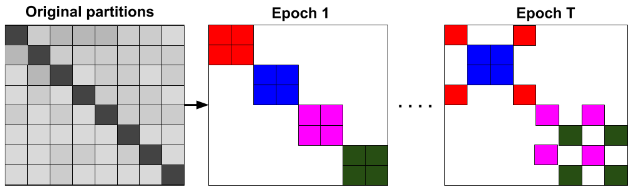

The Cluster-GCN algorithm has two stages:
1. `ClusterData` converts a `Data` object into a dataset of subgraphs containing `num_parts` partitions.
2. Given a user-defined `batch_size`, `ClusterLoader` implements the stochastic partitioning scheme (chart above) in order to create mini-batches.

Mini-batches are created in below. Here, we partition the initial graph into 128 partitions, and use a `batch_size` of 32 subgraphs to form mini-batches (leaving us with 4 batches per epoch). After a single epoch, each node has been seen exactly once.

In [3]:
from torch_geometric.loader import ClusterData, ClusterLoader
torch.manual_seed(12345)

cluster_data = ClusterData(data, num_parts=128)  # 1. Create subgraphs.
train_loader = ClusterLoader(cluster_data, batch_size=32, shuffle=True)  # 2. Stochastic partioning scheme.

print()
total_num_nodes = 0
for step, sub_data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of nodes in the current batch: {sub_data.num_nodes}')
    print(sub_data)
    print()
    total_num_nodes += sub_data.num_nodes

print(f'Iterated over {total_num_nodes} of {data.num_nodes} nodes!')

Computing METIS partitioning...
Done!



Step 1:
Number of nodes in the current batch: 4928
Data(x=[4928, 500], y=[4928], train_mask=[4928], val_mask=[4928], test_mask=[4928], edge_index=[2, 16174])

Step 2:
Number of nodes in the current batch: 4937
Data(x=[4937, 500], y=[4937], train_mask=[4937], val_mask=[4937], test_mask=[4937], edge_index=[2, 17832])

Step 3:
Number of nodes in the current batch: 4927
Data(x=[4927, 500], y=[4927], train_mask=[4927], val_mask=[4927], test_mask=[4927], edge_index=[2, 14712])

Step 4:
Number of nodes in the current batch: 4925
Data(x=[4925, 500], y=[4925], train_mask=[4925], val_mask=[4925], test_mask=[4925], edge_index=[2, 18006])

Iterated over 19717 of 19717 nodes!


With or without Cluster-GCN, the code to implement GNN is the same:

In [4]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
torch.manual_seed(12345)

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(500, 16)
  (conv2): GCNConv(16, 3)
)


Iterate over each mini-batch, and optimize each batch independently from each other:

In [5]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
torch.manual_seed(12345)

def train(model):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    for sub_data in train_loader:
        out = model(sub_data.x, sub_data.edge_index)
        loss = criterion(out[sub_data.train_mask], sub_data.y[sub_data.train_mask])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test(model):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask] == data.y[mask]
        accs.append(int(correct.sum()) / int(mask.sum()))
    return accs

model = GCN(hidden_channels=16)

for epoch in range(1, 11):
    loss = train(model)
    train_acc, val_acc, test_acc = test(model)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train: 0.3333, Val Acc: 0.4160, Test Acc: 0.4070
Epoch: 002, Train: 0.7167, Val Acc: 0.5600, Test Acc: 0.5500
Epoch: 003, Train: 0.6500, Val Acc: 0.5180, Test Acc: 0.5000
Epoch: 004, Train: 0.8833, Val Acc: 0.6340, Test Acc: 0.6290
Epoch: 005, Train: 0.9500, Val Acc: 0.7660, Test Acc: 0.7500
Epoch: 006, Train: 0.9000, Val Acc: 0.6940, Test Acc: 0.6680
Epoch: 007, Train: 0.7833, Val Acc: 0.6560, Test Acc: 0.6830
Epoch: 008, Train: 0.9333, Val Acc: 0.7560, Test Acc: 0.7340
Epoch: 009, Train: 0.9500, Val Acc: 0.7660, Test Acc: 0.7450
Epoch: 010, Train: 0.9500, Val Acc: 0.7200, Test Acc: 0.6980


<br>

## Customizing Aggregations within Message Passing

The performance of GNNs with different aggregation functions differs when applied to distinct tasks and datasets. Using multiple aggregations can potentially gain substantial improvements. It converges much faster than just using mean aggregation.

In [6]:
import copy
import torch.nn.functional as F
from torch_geometric.nn import (
    Aggregation,
    MaxAggregation,
    MeanAggregation,
    MultiAggregation,
    SAGEConv,
    SoftmaxAggregation,
    StdAggregation,
    SumAggregation,
    VarAggregation,
)

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, aggr='mean', aggr_kwargs=None):
        super().__init__()
        self.conv1 = SAGEConv(
            dataset.num_node_features,
            hidden_channels,
            aggr=aggr,
            aggr_kwargs=aggr_kwargs,
        )
        self.conv2 = SAGEConv(
            hidden_channels,
            dataset.num_classes,
            aggr=copy.deepcopy(aggr),
            aggr_kwargs=aggr_kwargs,
        )

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [7]:
torch.manual_seed(12345)

model = GNN(
    hidden_channels=16,
    aggr=[
        MeanAggregation(),
        MaxAggregation(),
        SumAggregation(),
        StdAggregation(),
        VarAggregation(),
    ]
)
print(model)

for epoch in range(1, 11):
    loss = train(model)
    train_acc, val_acc, test_acc = test(model)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

GNN(
  (conv1): SAGEConv(500, 16, aggr=['MeanAggregation()', 'MaxAggregation()', 'SumAggregation()', 'StdAggregation()', 'VarAggregation()'])
  (conv2): SAGEConv(16, 3, aggr=['MeanAggregation()', 'MaxAggregation()', 'SumAggregation()', 'StdAggregation()', 'VarAggregation()'])
)
Epoch: 001, Train: 0.6333, Val Acc: 0.4100, Test Acc: 0.3960
Epoch: 002, Train: 0.8333, Val Acc: 0.6700, Test Acc: 0.6440
Epoch: 003, Train: 0.7500, Val Acc: 0.4800, Test Acc: 0.4570
Epoch: 004, Train: 0.9000, Val Acc: 0.7120, Test Acc: 0.6930
Epoch: 005, Train: 0.9500, Val Acc: 0.7520, Test Acc: 0.7380
Epoch: 006, Train: 0.9667, Val Acc: 0.7620, Test Acc: 0.7400
Epoch: 007, Train: 0.9500, Val Acc: 0.7680, Test Acc: 0.7390
Epoch: 008, Train: 0.8500, Val Acc: 0.6200, Test Acc: 0.5990
Epoch: 009, Train: 0.9500, Val Acc: 0.7460, Test Acc: 0.7410
Epoch: 010, Train: 0.9667, Val Acc: 0.7160, Test Acc: 0.6620


Use different initial temperatures for SoftmaxAggregation

In [8]:
torch.manual_seed(12345)

model = GNN(
    hidden_channels=16,
    aggr=MultiAggregation([
        SoftmaxAggregation(t=0.01, learn=True),
        SoftmaxAggregation(t=1, learn=True),
        SoftmaxAggregation(t=100, learn=True),
    ])
)
print(model)

for epoch in range(1, 11):
    loss = train(model)
    train_acc, val_acc, test_acc = test(model)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

GNN(
  (conv1): SAGEConv(500, 16, aggr=MultiAggregation([
    SoftmaxAggregation(learn=True),
    SoftmaxAggregation(learn=True),
    SoftmaxAggregation(learn=True),
  ], mode=cat))
  (conv2): SAGEConv(16, 3, aggr=MultiAggregation([
    SoftmaxAggregation(learn=True),
    SoftmaxAggregation(learn=True),
    SoftmaxAggregation(learn=True),
  ], mode=cat))
)
Epoch: 001, Train: 0.8500, Val Acc: 0.7120, Test Acc: 0.7080
Epoch: 002, Train: 0.9833, Val Acc: 0.7160, Test Acc: 0.6960
Epoch: 003, Train: 0.7667, Val Acc: 0.6560, Test Acc: 0.6760
Epoch: 004, Train: 0.9000, Val Acc: 0.7620, Test Acc: 0.7370
Epoch: 005, Train: 0.9500, Val Acc: 0.7740, Test Acc: 0.7520
Epoch: 006, Train: 0.9333, Val Acc: 0.7500, Test Acc: 0.7300
Epoch: 007, Train: 0.9667, Val Acc: 0.8060, Test Acc: 0.7720
Epoch: 008, Train: 0.9667, Val Acc: 0.8020, Test Acc: 0.7610
Epoch: 009, Train: 1.0000, Val Acc: 0.7960, Test Acc: 0.7600
Epoch: 010, Train: 0.9833, Val Acc: 0.8000, Test Acc: 0.7740
